In [3]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from lightgbm import LGBMClassifier
import optuna

In [4]:
df = pd.read_csv('Employee.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [6]:
X = df.drop('LeaveOrNot', axis=1)
y = pd.DataFrame(df['LeaveOrNot'])

cat_cols = list(X.select_dtypes('object').columns)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

X_train[cat_cols] = X_train[cat_cols].apply(lambda row: row.astype('category'))
X_valid[cat_cols] = X_train[cat_cols].apply(lambda row: row.astype('category'))

sample_row = X.loc[0].to_dict()

In [7]:
model = LGBMClassifier()

model.fit(X_train, y_train, categorical_feature=cat_cols)
preds = model.predict(X_valid)

print(f'accuracy: {accuracy_score(y_valid, preds)}')

[LightGBM] [Info] Number of positive: 1126, number of negative: 2131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 3257, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345717 -> initscore=-0.637920
[LightGBM] [Info] Start training from score -0.637920
accuracy: 0.7435530085959885


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


              precision    recall  f1-score   support

           0       0.79      0.83      0.81       922
           1       0.64      0.57      0.60       474

    accuracy                           0.74      1396
   macro avg       0.71      0.70      0.71      1396
weighted avg       0.74      0.74      0.74      1396



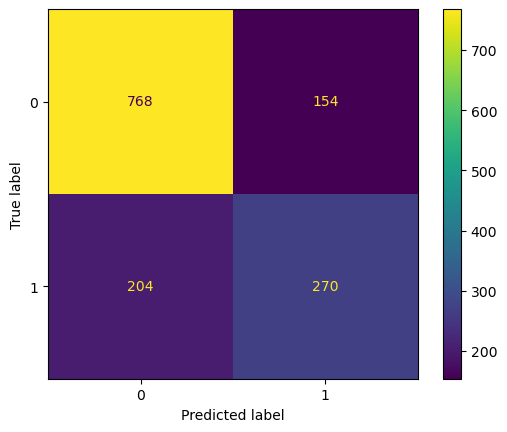

In [8]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_valid, preds))

# Optuna

In [13]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'rf', 'dart'])
    clf = LGBMClassifier(n_estimators=n_estimators, booster_type=boosting_type)
    clf.fit(X_train, y_train)
    return clf.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

model_params_list = ['n_estimators', 'booster']
model_params = dict()

for key, value in study.best_trial.params.items():
    if key in model_params_list:
        model_params[key] = value

model = LGBMClassifier(**model_params)
model.fit(X_train, y_train)

[I 2024-10-11 13:19:57,136] A new study created in memory with name: no-name-0ee512f1-d81f-4b19-b4f0-ad7276f545ad
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-10-11 13:19:57,189] Trial 0 finished with value: 0.7421203438395415 and parameters: {'n_estimators': 31, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.7421203438395415.
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConv

[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Info] Number of positive: 1126, number of negative: 2131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 3257, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345717 -> initscore=-0.637920
[LightGBM] [Info] Start training from score -0.637920
[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Info] Number of positive: 1126, number of negative: 2131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can se

[I 2024-10-11 13:19:57,430] Trial 1 finished with value: 0.6561604584527221 and parameters: {'n_estimators': 373, 'boosting_type': 'rf'}. Best is trial 0 with value: 0.7421203438395415.
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-10-11 13:19:57,534] Trial 2 finished with value: 0.7421203438395415 and parameters: {'n_estimators': 172, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.7421203438395415.


[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Info] Number of positive: 1126, number of negative: 2131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 3257, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345717 -> initscore=-0.637920
[LightGBM] [Info] Start training from score -0.637920
[LightGBM] [Warning] Unknown parameter: booster_type
[LightGBM] [Info] Number of positive: 1126, number of negative: 2131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(n_estimators=31)

In [14]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [15]:
from pydantic import BaseModel, ValidationError

class Employee(BaseModel):
    Education: object
    JoiningYear: int
    City: object
    PaymentTier: int
    Age: int
    Gender: object
    EverBenched: object
    ExperienceInCurrentDomain: int

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print(sample_row)
employee = Employee(**sample_row)
inputs = pd.DataFrame([employee.model_dump()])
inputs[cat_cols] = inputs[cat_cols].apply(lambda row: row.astype('category'))
pred = loaded_model.predict(inputs)[0]
pred


{'Education': 'Bachelors', 'JoiningYear': 2017, 'City': 'Bangalore', 'PaymentTier': 3, 'Age': 34, 'Gender': 'Male', 'EverBenched': 'No', 'ExperienceInCurrentDomain': 0}


0

In [16]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        employee = Employee(**request.json)
        inputs = pd.DataFrame([employee.model_dump()])
        inputs[cat_cols] = inputs[cat_cols].apply(lambda row: row.astype('category'))
        pred = loaded_model.predict(inputs)[0]
        response = {
            'prediction': int(pred)
        }

        return jsonify(response), 200
        
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 13:20:09] "POST /predict HTTP/1.1" 200 -
